<div >
<img src = "figs/ans_banner_1920x200.png" />
</div>

# Caso-taller: Reconocimiento facial con K-medias y K-medoides

En este caso-taller vamos a aplicar K-medias y K-medoides para agrupar rostros de indiviudos. Utilizaremos la base de datos conocida como Caras Olivetti. Esta base contiene diez imágenes diferentes de  40 personas distintas. Para algunas personas, las imágenes se tomaron en diferentes momentos, variando la iluminación, las expresiones faciales (ojos abiertos/cerrados, sonriendo/sin sonreír) y los detalles faciales (gafas/sin gafas). Todas las imágenes fueron tomadas contra un fondo homogéneo oscuro con los sujetos en una posición frontal erguida (con tolerancia a algún movimiento lateral). Esta base viene incluida dentro de la libraría `scikit-learn` y fueron provistas por T&T Laboratories Cambridge para que la comunidad académica la utilice para la evaluación de modelos predictivos. 

## Instrucciones generales

1. Para desarrollar el *cuaderno* primero debe descargarlo.

2. Para responder cada inciso deberá utilizar el espacio debidamente especificado.

3. La actividad será calificada sólo si sube el *cuaderno* de jupyter notebook con extensión `.ipynb` en la actividad designada como "entrega calificada por el personal".

4. El archivo entregado debe poder ser ejecutado localmente por el tutor. Sea cuidadoso con la especificación de la ubicación de los archivos de soporte, guarde la carpeta de datos en el mismo `path` de su cuaderno, por ejemplo: `data`.

## Integrantes

Grupo 29

|**Nombre**|**Email**|
|---|---|
|Jaramillo Simon|s.jaramillo3@uniandes.edu.co|
|Mendoza Canales Hubert Ronald|h.mendozac@uniandes.edu.co|
|Montero Ramirez Daniel Eduardo|de.montero@uniandes.edu.co|

## Desarrollo


#### Config

##### Carga de Bibliotecas

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

# python
import os
import ssl
import sys
import csv
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import session_info

from pathlib import Path
from inspect import cleandoc

# stat
from scipy.stats import mode

# sklearn
from sklearn.datasets import fetch_olivetti_faces
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids

# skleann metrics
from sklearn.metrics import (
    accuracy_score,
    silhouette_score, 
    adjusted_rand_score, 
    normalized_mutual_info_score,
    homogeneity_score,
    completeness_score,
    v_measure_score
)

# typings
from pandas import DataFrame as PandasDF
from typing import List

# setup
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('max_colwidth', None)
# decimals
np.set_printoptions(precision=6)

##### Información de Sesión

In [3]:
session_info.show(html=False)

-----
ipykernel           6.29.5
matplotlib          3.8.0
numpy               1.26.4
pandas              1.5.3
scipy               1.10.1
seaborn             0.13.2
session_info        v1.0.1
sklearn             1.6.1
sklearn_extra       0.3.0
-----
IPython             8.32.0
jupyter_client      8.6.3
jupyter_core        5.7.2
jupyterlab          4.2.5
notebook            7.0.8
-----
Python 3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]
Windows-10-10.0.26100-SP0
-----
Session information updated at 2025-08-24 18:25


### utils

In [5]:
# utils

# desabilitar SSL verificacion para entornos locales
# cargar el dataset sklearn
if not os.environ.get('CI'):
    ssl._create_default_https_context =\
        ssl._create_unverified_context

# rutas absolutas
here: Path = Path.cwd().absolute()
data: Path = here / 'data'
oliveti_dataset: Path = data / 'oliveti_dataset.npy.npz'

### 1.Carga de datos 

Los datos pueden ser bajados directamente utilizando la librería `scikit-learn`,  la función que le permite hacer esto es `fetch_olivetti_faces`. 

In [8]:
# Utilice este espacio para escribir el código.
if not oliveti_dataset.exists():
    faces = fetch_olivetti_faces(data_home=str(data))
    
    np.savez_compressed(
        str(oliveti_dataset),
        descr=faces.DESCR,
        data=faces.data,
        images=faces.images,
        target=faces.target
    )

with np.load(
    str(oliveti_dataset), allow_pickle=True
) as data:
    oliveti_descr = data['descr']
    oliveti_data = data['data']
    oliveti_images = data['images']
    oliveti_target = data['target']

(Utilice este espacio para describir su procedimiento).

Para cargar los datos, se utilizó la función **fetch_olivetti_faces** de la biblioteca scikit-learn. El dataset se descargó y almacenó de manera local en la carpeta data, dentro de un archivo comprimido en formato .npz. En este archivo se guardaron tanto la descripción del dataset, como las imágenes, los vectores de características y las etiquetas de cada individuo.

Con el propósito de optimizar la gestión de recursos, se implementó un procedimiento de verificación previa que determina la existencia del archivo local. En caso de no encontrarlos, se procedía a la descarga automática y almacenamiento, lo que facilita su reutilización en futuras ejecuciones sin necesidad de repetir el proceso de descarga.

Fuentes consultadas sobre el dataset **fetch_olivetti_faces**:

- [sklearn.datasets.fetch_olivetti_faces](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html)
- [El conjunto de datos Olivetti Faces](https://scikit-learn.org/stable/datasets/real_world.html#olivetti-faces-dataset)

### 2.  Análisis preliminar 

#### 2.1. Describa los contenidos de la base de datos, tenga en cuenta que debe detallar los elementos, la dimensión de la base, y la dimensión de las imágenes. 

In [12]:
# Utilice este espacio para escribir el código.
n_samples, n_features = oliveti_data.shape
n_classes = len(oliveti_target)
h, w = oliveti_images.shape[1], oliveti_images.shape[2]

print(oliveti_descr,'\n') 

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position
    (with tolerance for some side movement).

**Data Set Characteristics:**

=================   =====================
Classes              

In [13]:
#Aplasto los datos para poder trabajar "mas intuitivamente" con las matrices
X = pd.DataFrame(oliveti_data)
y = pd.DataFrame(oliveti_target, columns=['name'])

df = y.join(X)
df.head()

name         0         1         2         3         4         5         6  \
0     0  0.309917  0.367769  0.417355  0.442149  0.528926  0.607438  0.657025   
1     0  0.454545  0.471074  0.512397  0.557851  0.595041  0.640496  0.681818   
2     0  0.318182  0.400826  0.491736  0.528926  0.586777  0.657025  0.681818   
3     0  0.198347  0.194215  0.194215  0.194215  0.190083  0.190083  0.243802   
4     0  0.500000  0.545455  0.582645  0.623967  0.648760  0.690083  0.694215   

          7         8         9        10        11        12        13  \
0  0.677686  0.690083  0.685950  0.702479  0.698347  0.694215  0.698347   
1  0.702479  0.710744  0.702479  0.710744  0.698347  0.702479  0.706612   
2  0.685950  0.702479  0.698347  0.702479  0.706612  0.706612  0.714876   
3  0.404959  0.483471  0.516529  0.537190  0.566116  0.574380  0.586777   
4  0.714876  0.723140  0.731405  0.739669  0.739669  0.764463  0.756198   

         14        15        16        17        18        19        20  \
0  0.690083  0.694215  0.690083  0.698347  0.702479  0.702479  0.698347   
1  0.706612  0.714876  0.714876  0.706612  0.698347  0.714876  0.698347   
2  0.710744  0.706612  0.706612  0.706612  0.723140  0.719008  0.719008   
3  0.611570  0.632231  0.640496  0.657025  0.673554  0.694215  0.702479   
4  0.764463  0.785124  0.793388  0.797521  0.814050  0.809917  0.809917   

         21        22        23        24        25        26        27  \
0  0.706612  0.710744  0.719008  0.727273  0.756198  0.772727  0.776860   
1  0.723140  0.731405  0.743802  0.756198  0.772727  0.768595  0.785124   
2  0.710744  0.710744  0.752066  0.756198  0.764463  0.785124  0.797521   
3  0.719008  0.727273  0.719008  0.723140  0.710744  0.739669  0.747934   
4  0.818182  0.830579  0.830579  0.842975  0.838843  0.838843  0.838843   

         28        29        30        31        32        33        34  \
0  0.776860  0.756198  0.760331  0.780992  0.760331  0.768595  0.756198   
1  0.764463  0.756198  0.731405  0.743802  0.735537  0.719008  0.706612   
2  0.838843  0.826446  0.842975  0.847107  0.830579  0.818182  0.793388   
3  0.756198  0.756198  0.764463  0.772727  0.785124  0.785124  0.805785   
4  0.830579  0.818182  0.805785  0.801653  0.797521  0.793388  0.793388   

         35        36        37        38        39        40        41  \
0  0.739669  0.743802  0.739669  0.743802  0.719008  0.719008  0.714876   
1  0.714876  0.719008  0.710744  0.710744  0.706612  0.702479  0.702479   
2  0.768595  0.760331  0.756198  0.739669  0.710744  0.719008  0.702479   
3  0.818182  0.805785  0.809917  0.793388  0.789256  0.785124  0.776860   
4  0.785124  0.797521  0.801653  0.793388  0.793388  0.789256  0.797521   

         42        43        44        45        46        47        48  \
0  0.719008  0.719008  0.723140  0.727273  0.735537  0.714876  0.723140   
1  0.702479  0.690083  0.681818  0.690083  0.685950  0.669421  0.677686   
2  0.702479  0.702479  0.706612  0.706612  0.719008  0.706612  0.710744   
3  0.785124  0.768595  0.785124  0.776860  0.780992  0.789256  0.780992   
4  0.785124  0.785124  0.772727  0.764463  0.764463  0.747934  0.739669   

         49        50        51        52        53        54        55  \
0  0.719008  0.714876  0.710744  0.702479  0.706612  0.698347  0.677686   
1  0.665289  0.652893  0.657025  0.640496  0.619835  0.615702  0.578512   
2  0.710744  0.706612  0.710744  0.702479  0.694215  0.690083  0.669421   
3  0.776860  0.776860  0.776860  0.768595  0.768595  0.756198  0.743802   
4  0.739669  0.723140  0.710744  0.702479  0.685950  0.673554  0.590909   

         56        57        58        59        60        61        62  \
0  0.657025  0.632231  0.566116  0.524793  0.446281  0.371901  0.330579   
1  0.500000  0.359504  0.314050  0.214876  0.194215  0.190083  0.185950   
2  0.636364  0.636364  0.599174  0.545455  0.475207  0.400826  0.355372   
3  0.735537  0.727273  0.685950  0.673554  0.615702  0.5826

In [14]:
X.describe()

0           1           2           3           4           5     \
count  400.000000  400.000000  400.000000  400.000000  400.000000  400.000000   
mean     0.400134    0.434236    0.476281    0.518481    0.554845    0.588729   
std      0.180695    0.189504    0.194742    0.193313    0.188593    0.178481   
min      0.086777    0.066116    0.090909    0.041322    0.107438    0.107438   
25%      0.243802    0.267562    0.314050    0.383264    0.446281    0.515496   
50%      0.392562    0.458678    0.512397    0.545455    0.584711    0.615702   
75%      0.528926    0.575413    0.636364    0.666322    0.702479    0.714876   
max      0.805785    0.822314    0.871901    0.892562    0.871901    0.871901   

             6           7           8           9           10          11    \
count  400.000000  400.000000  400.000000  400.000000  400.000000  400.000000   
mean     0.621426    0.647510    0.664814    0.676591    0.686209    0.692572   
std      0.167109    0.155024    0.147616    0.143583    0.136356    0.131580   
min      0.115702    0.115702    0.119835    0.140496    0.140496    0.148760   
25%      0.544421    0.581612    0.599174    0.611570    0.619835    0.628099   
50%      0.652893    0.669421    0.683884    0.702479    0.714876    0.719008   
75%      0.735537    0.757231    0.772727    0.780992    0.789256    0.789256   
max      0.871901    0.871901    0.871901    0.871901    0.863636    0.863636   

             12          13          14          15          16          17    \
count  400.000000  400.000000  400.000000  400.000000  400.000000  400.000000   
mean     0.699401    0.704876    0.710155    0.713884    0.718233    0.722345   
std      0.128450    0.126246    0.124832    0.125469    0.126090    0.127646   
min      0.161157    0.169421    0.181818    0.173554    0.165289    0.185950   
25%      0.636364    0.643595    0.648760    0.655992    0.665289    0.669421   
50%      0.735537    0.743802    0.752066    0.760331    0.768595    0.772727   
75%      0.793388    0.793388    0.793388    0.801653    0.801653    0.805785   
max      0.859504    0.867769    0.871901    0.876033    0.884298    0.888430   

             18          19          20          21          22          23    \
count  400.000000  400.000000  400.000000  400.000000  400.000000  400.000000   
mean     0.725145    0.727614    0.729700    0.730062    0.730961    0.729907   
std      0.129569    0.130954    0.131288    0.135020    0.135711    0.137272   
min      0.152893    0.169421    0.157025    0.148760    0.161157    0.152893   
25%      0.673554    0.685950    0.694215    0.690083    0.690083    0.689050   
50%      0.772727    0.768595    0.774793    0.776860    0.778926    0.778926   
75%      0.809917    0.814050    0.818182    0.822314    0.822314    0.822314   
max      0.892562    0.896694    0.900826    0.900826    0.900826    0.900826   

             24          25          26          27          28          29    \
count  400.000000  400.000000  400.000000  400.000000  400.000000  400.000000   
mean     0.729721    0.730289    0.728409    0.726797    0.725351    0.724112   
std      0.137320    0.135546    0.134700    0.134171    0.133041    0.132261   
min      0.157025    0.144628    0.144628    0.144628    0.148760    0.165289   
25%      0.685950    0.677686    0.681818    0.673554    0.669421    0.669421   
50%      0.780992    0.780992    0.776860    0.770661    0.764463    0.768595   
75%      0.822314    0.822314    0.822314    0.818182    0.818182    0.818182   
max      0.904959    0.900826    0.896694    0.900826    0.900826    0.896694   

             30          31          32          33          34          35    \
count  400.000000  400.000000  400.000000  400.000000  400.000000  400.000000   
mean     0.724246    0.725744    0.726353    0.726250    0.726901    0.725816   
std      0.129363    0.126623    0.124510    0.123213    0.121916    0.123161   
min      0.202479    0.181818    0.2148

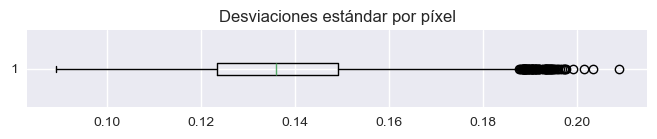

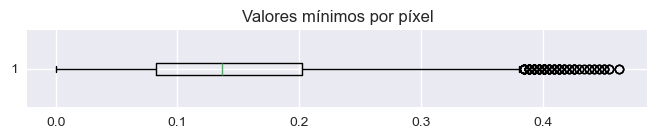

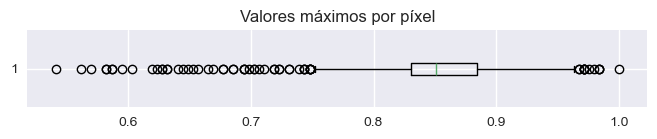

In [15]:
# Métricas por píxel
metricas = {
    "Desviaciones estándar por píxel": X.std(axis=0),
    "Valores mínimos por píxel": X.min(axis=0),
    "Valores máximos por píxel": X.max(axis=0),
}
for titulo, valores in metricas.items():
    plt.figure(figsize=(8, 1))
    plt.boxplot(valores, vert=False)
    plt.title(titulo)
    plt.grid(True)
    plt.show()


Usando la estadisticas de los datos se evidencia que el promediod e los pixeles está concentrado entre 0.48 y 0.62 que correspondena  la intensidad de los pixesles. Las desviaciones en general son muy bajas mostrando que hay baja variabilidad en los datos y que el rango de datos está entre 0 y 1. Se evidencian datos homogeneos a nivel general sin valores atípicos marcados.

In [17]:
# Personas que aparecen en el dataset (n_clases)
y.name.unique().shape

(40,)

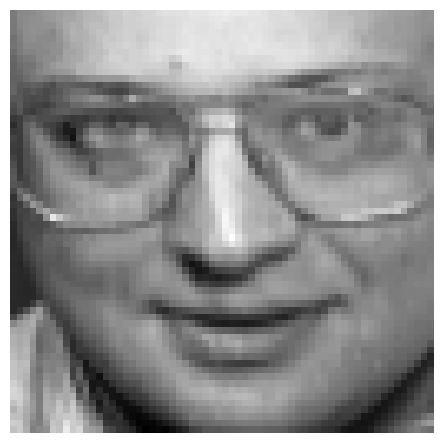

In [18]:
# Se grafica una imagen del dataset de muestra
img1 = X.iloc[300].to_numpy().reshape(h,w)
plt.imshow(img1, cmap=plt.cm.gray)
plt.xticks([])
plt.yticks([])
plt.show()

In [19]:
print(cleandoc(f"""
    La base de datos contiene {n_samples} imágenes en total.
    Cada imagen está representada por {n_features} píxeles (un vector 1D).
    Las dimensiones originales de cada imagen son: {h} de alto x {w} de ancho.
    Hay un total de {n_classes} individuos diferentes en el dataset.
    
    Los elementos del dataset son:
    - data: Matriz donde cada fila es una imagen aplanada.
    - images: Array 3D con las imágenes en su formato original (alto x ancho).
    - target: Array con las etiquetas numéricas (ID) de cada persona.
    - target_names: Array con los nombres de las personas correspondientes a cada etiqueta.
"""))

La base de datos contiene 400 imágenes en total.
Cada imagen está representada por 4096 píxeles (un vector 1D).
Las dimensiones originales de cada imagen son: 64 de alto x 64 de ancho.
Hay un total de 400 individuos diferentes en el dataset.

Los elementos del dataset son:
- data: Matriz donde cada fila es una imagen aplanada.
- images: Array 3D con las imágenes en su formato original (alto x ancho).
- target: Array con las etiquetas numéricas (ID) de cada persona.
- target_names: Array con los nombres de las personas correspondientes a cada etiqueta.


#### 2.2. Genere una figura con una imágen de cada uno de los individuos

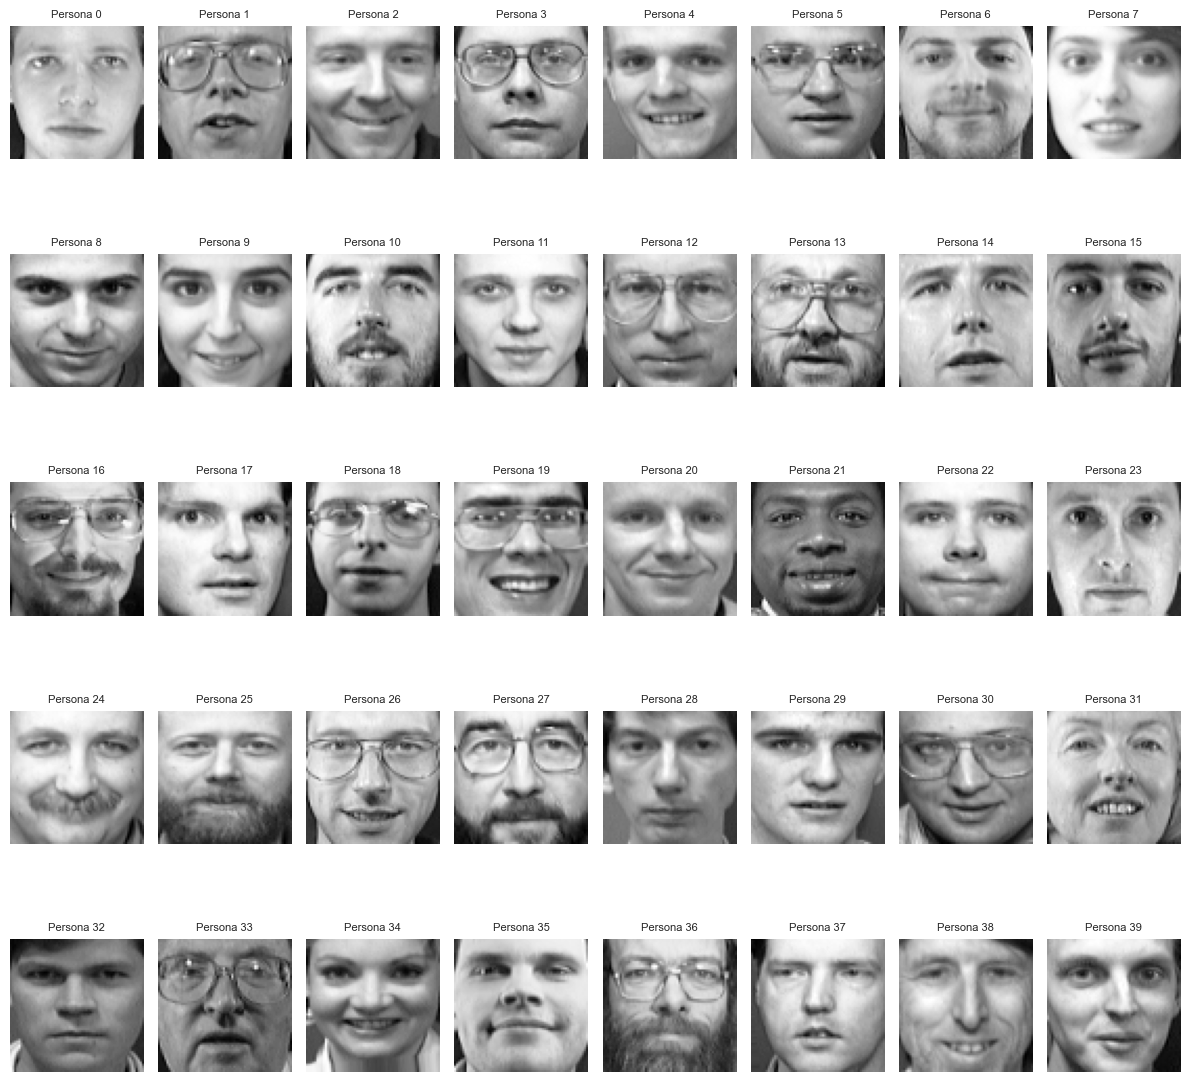

In [22]:
# Utilice este espacio para escribir el código.
rostros_df = df.groupby("name").first().reset_index()

fig, axes = plt.subplots(5, 8, figsize=(12, 12))

for ax, (_, row) in zip(axes.flat, rostros_df.iterrows()):
    ax.imshow(row.drop("name").values.reshape(h, w), cmap="gray")
    ax.set_title(f"Persona {int(row['name'])}", fontsize=8)
    ax.axis("off")
    ax.set_aspect("equal")

plt.tight_layout()
plt.show()


Se selecciona la primera imagen de cada persona para representarlos graficamente en conjuntos de 4 filas. De esta forma se puede explorar visualmente las imagenes de las 40 diferentes personas en la base.

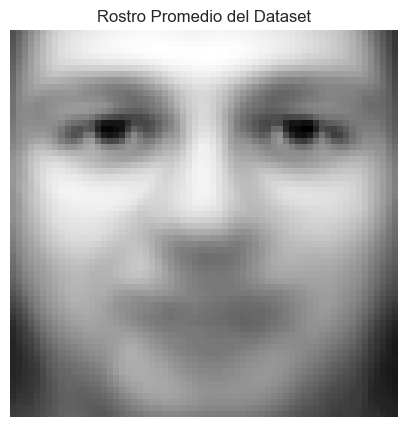

In [25]:
# Calcular el promedio de los píxeles a través de todas las imágenes
# axis=0 significa que calculamos el promedio para cada columna (píxel)
average_face = oliveti_data.mean(axis=0)

# Redimensionar el vector promedio a las dimensiones de una imagen (64x64)
average_face_image = average_face.reshape(h, w)

# Graficamos el rostro promedio
plt.figure(figsize=(5, 7))
plt.imshow(average_face_image, cmap='gray')
plt.title('Rostro Promedio del Dataset')
plt.xticks([])
plt.yticks([])
plt.show()

Al clacular el rostro promedio se tiene un insumo para poder estandarizar las imagenes del dataset. Al poder repesentar lo que hace común a los rostros, se puede proceder a tener un conjunto de imagenes donde se extrae el rostro promedio para así resltar las diferencias o lo que hace único a cada imagen dentro del conjunto. Este procedimiento representa un paso importante para los siguientes puntos ya que se espera que al tener las imagenes depuradas se puden alcanzar mejores desempeños en los algoritmos de clasificación.

#### 2.3. Transforme las imágenes en un data frame donde cada columna contiene los valores estandarizados del nivel de gris en la imagen y una columna con la etiqueta de cada imagen. 

In [29]:
# Utilice este espacio para escribir el código.
# Restar el rostro promedio a cada imagen en el dataset
X_centered = oliveti_data - average_face
df_images = pd.DataFrame(X_centered)

# Estandarizar los valores de gris
scaler = StandardScaler()
df_images_std = pd.DataFrame(
    scaler.fit_transform(df_images),
    columns=[f"pixel_{i}" for i in range(df_images.shape[1])]
)

# Agregar columna con etiquetas (individuo)
df_images_std["target"] = oliveti_target

df_images_std.head()

pixel_0   pixel_1   pixel_2   pixel_3   pixel_4   pixel_5   pixel_6  \
0 -0.499903 -0.351181 -0.302961 -0.395361 -0.137608  0.104953  0.213296   
1  0.301499  0.194640  0.185686  0.203914  0.213404  0.290404  0.361849   
2 -0.454109 -0.176519  0.079458  0.054095  0.169528  0.383129  0.361849   
3 -1.118128 -1.268161 -1.450221 -1.679522 -1.936544 -2.236356 -2.262576   
4  0.553368  0.587631  0.546860  0.546357  0.498601  0.568579  0.436125   

    pixel_7   pixel_8   pixel_9  pixel_10  pixel_11  pixel_12  pixel_13  \
0  0.194895  0.171393  0.065267  0.119474  0.043943 -0.040424 -0.051781   
1  0.355027  0.311534  0.180529  0.180159  0.043943  0.023997  0.013765   
2  0.248272  0.255478  0.151713  0.119474  0.106831  0.056207  0.079310   
3 -1.566562 -1.230019 -1.116164 -1.094231 -0.962269 -0.974521 -0.936642   
4  0.435093  0.395618  0.382236  0.392558  0.358385  0.507151  0.407036   

   pixel_14  pixel_15  pixel_16  pixel_17  pixel_18  pixel_19  pixel_20  \
0 -0.160996 -0.156963 -0.223539 -0.188240 -0.175147 -0.192173 -0.239113   
1 -0.028421  0.007914 -0.026660 -0.123413 -0.207080 -0.097390 -0.239113   
2  0.004723 -0.058037 -0.092287 -0.123413 -0.015487 -0.065795 -0.081543   
3 -0.790731 -0.651594 -0.617297 -0.512372 -0.398672 -0.255362 -0.207599   
4  0.435594  0.568496  0.596789  0.589678  0.687019  0.629282  0.611766   

   pixel_21  pixel_22  pixel_23  pixel_24  pixel_25  pixel_26  pixel_27  \
0 -0.173899 -0.149157 -0.079495 -0.017852  0.191385  0.329425  0.373588   
1 -0.051327  0.003277  0.101346  0.193056  0.313480  0.298710  0.435261   
2 -0.143256 -0.149157  0.161627  0.193056  0.252433  0.421572  0.527772   
3 -0.081970 -0.027209 -0.079495 -0.047982 -0.144378  0.083700  0.157730   
4  0.653462  0.734964  0.734290  0.825778  0.801863  0.820875  0.836140   

   pixel_28  pixel_29  pixel_30  pixel_31  pixel_32  pixel_33  pixel_34  \
0  0.387646  0.242905  0.279291  0.436863  0.273229  0.344105  0.240609   
1  0.294350  0.242905  0.055410  0.142789  0.073852 -0.058848 -0.166628   
2  0.854128  0.774699  0.918949  0.959661  0.838131  0.747059  0.546037   
3  0.232152  0.242905  0.311274  0.371513  0.472606  0.478423  0.647846   
4  0.791930  0.712135  0.631103  0.600238  0.572295  0.545582  0.546037   

   pixel_35  pixel_36  pixel_37  pixel_38  pixel_39  pixel_40  pixel_41  \
0  0.112622  0.150398  0.122116  0.173489  0.001970  0.034312  0.029595   
1 -0.088938 -0.053993 -0.112884 -0.091001 -0.096548 -0.095779 -0.065873   
2  0.347776  0.286659  0.256402  0.140428 -0.063708  0.034312 -0.065873   
3  0.750897  0.661378  0.692831  0.570225  0.560239  0.554675  0.506937   
4  0.482149  0.593247  0.625689  0.570225  0.593078  0.587198  0.666050   

   pixel_42  pixel_43  pixel_44  pixel_45  pixel_46  pixel_47  pixel_48  \
0  0.090664  0.124472  0.182846  0.236883  0.334569  0.228251  0.327347   
1 -0.034282 -0.091866 -0.125365 -0.036531 -0.026639 -0.098564  0.004332   
2 -0.034282  0.000850  0.059562  0.084986  0.214166  0.168830  0.239252   
3  0.590447  0.495337  0.645164  0.601435  0.665676  0.763040  0.738458   
4  0.590447  0.618958  0.552701  0.510297  0.545274  0.465934  0.444807   

   pixel_49  pixel_50  pixel_51  pixel_52  pixel_53  pixel_54  pixel_55  \
0  0.347138  0.378781  0.400140  0.396450  0.479966  0.488352  0.454918   
1 -0.034252 -0.060725  0.026513 -0.031527 -0.107063 -0.056608 -0.186659   
2  0.288463  0.320180  0.400140  0.396450  0.396104  0.433856  0.401453   
3  0.757866  0.818286  0.859989  0.852959  0.899272  0.869824  0.882636   
4  0.493827  0.437381  0.400140  0.396450  0.340197  0.324864 -0.106462   

   pixel_56  pixel_57  pixel_58  pixel_59  pixel_60  pixel_61  pixel_62  \
0  0.457449  0.458926  0.281057  0.249447  0.005484 -0.229572 -0.269862   
1 -0.544745 -1.187446 -1.182407 -1.461828 -1.373951 -1.228450 -1.083576   
2  0.325581  0.483871  0.472987  0.363532  0.163780 -0.070659 -0.130369   
3  0.958545  1.032662  0.976802  1.070859  0.932644  0.928219  0.753092   
4 -0.966721 -1.237336

Una vez que las imagenes han sido depuradas se procecede a usar el StandardScaler() para preparar nuestro conjunto de datos para los algoritmos de clasificación.

### 3. Clasificando de forma no supervisada

En esta sección trataremos de clasificar las imágenes de los individuos de forma no supervisada. Para ello utilizaremos los algoritmos de k-medias y k-medoides. Dado que sabemos que el dataset consta de 40 personas diferentes, utilizaremos esta información para pedirle a los algoritmos que encuentren k=40 clusters y examinaremos su precisión.


#### 3.1. Implemente k-medias sobre los datos estandarizados en el punto anterior. Al implementar utilice  `random_state=123` y `n_init=10`. (Esto puede tomar mucho tiempo y requerir mucho RAM, puede aprovechar los recursos de [Google Colab](https://colab.research.google.com/))

In [34]:
# Utilice este espacio para escribir el código.
k: int = 40
X = df_images_std.drop(columns=["target"])
y_true = df_images_std["target"]

kmeans = KMeans(n_clusters=k, random_state=123, n_init=10)
kmeans.fit(X)

# Etiquetas de los clusters asignados
labels_kmeans = kmeans.labels_

# Agregar los clusters al DataFrame
df_images_std["cluster_kmeans"] = labels_kmeans

df_images_std[["target", "cluster_kmeans"]].head()

target  cluster_kmeans
0       0               7
1       0              14
2       0               7
3       0               5
4       0              14

De acuerdo a lo solicitado en el enunciado, se define el número de clusters como 40, se entrena el modelo Kmeans de la librería Skitlearn y finalmente se visualiza a manera general el resultado de la clusterización.

#### 3.2. Evalúe la precisión del algoritmo para agrupar las imágenes de los individuos. 

In [37]:
# Utilice este espacio para escribir el código.
# Crear un mapeo entre cluster y clase real (target)
labels_map:dict = {}
for cluster in range(k):
    mask = labels_kmeans == cluster
    true_labels = df_images_std.loc[mask, "target"]
    labels_map[cluster] = mode(true_labels, keepdims=True).mode[0]

# Convertir clusters en predicciones de clases
y_pred = [labels_map[cluster] for cluster in labels_kmeans]

# Calcular precisión
measure_kmeans = v_measure_score(y_true, labels_kmeans)
print(cleandoc(f"""
    Algoritmo K-Means
    ARI: {adjusted_rand_score(y_true, labels_kmeans):.4f}
    NMI: {normalized_mutual_info_score(y_true,labels_kmeans):.4f}
    Homogeneity: {homogeneity_score(y_true, labels_kmeans):.4f}
    Completeness: {completeness_score(y_true, labels_kmeans):.4f}
    V-Measure: {measure_kmeans: .4f}
"""))

Algoritmo K-Means
ARI: 0.4685
NMI: 0.7819
Homogeneity: 0.7706
Completeness: 0.7935
V-Measure:  0.7819


- adjusted_rand_score (ARI) → similitud entre particiones, corrige por azar (1 = igual, 0 = aleatorio).
- normalized_mutual_info_score (NMI) → información compartida entre clústeres y clases, normalizada [0,1].
- homogeneity_score → cada clúster contiene solo muestras de una clase.
- completeness_score → todas las muestras de una clase caen en el mismo clúster.
- v_measure_score → media armónica de homogeneidad y completitud.

Se realiza el cálculo de la presición del algoritmo desde diferentes tipos de medición. No se calcula el accuracy, dado que al ser una medición sensible al valor de las etiquetas, y el algoritmo de Kmeans ser arbitrario en la asignación de las mismas, no es comparable el resultado del KMeans frente al Y que tenemos. Situación que no ocurre con el v_measure_score, por lo que se decide trabajar con esta medición.

#### 3.3. Usando PCA reduzca la dimensión de la matriz de predictores. Retenga el numero de componentes que explican el 95% de la varianza y vuelva a utilizar k-medias para clasificar las imágenes comentado si la precisión mejoró. 

In [40]:
# Utilice este espacio para escribir el código.
# Separar X (predictoras) y y (target real)
X = df_images_std.drop(columns=["target", "cluster_kmeans"])

# PCA reteniendo 95% de la varianza
pca = PCA(n_components=0.95, random_state=123)
X_pca = pca.fit_transform(X)

print(f"Número de componentes retenidos: {X_pca.shape[1]}")

# Aplicar K-Means en espacio reducido
kmeans_pca = KMeans(n_clusters=len(np.unique(y_true)), 
                    random_state=123, n_init=10)
labels_kmeans_pca = kmeans_pca.fit_predict(X_pca)

# Mapear clusters a clases reales
labels_map_pca:dict = {}
for cluster in np.unique(labels_kmeans_pca):
    mask = labels_kmeans_pca == cluster
    true_labels = y_true[mask]
    labels_map_pca[cluster] = mode(true_labels, keepdims=True).mode[0]

# Convertir clusters en predicciones de clases
y_pred_pca = [labels_map_pca[cluster] for cluster in labels_kmeans_pca]

# Calcular precisión
measure_kmeans_pca = v_measure_score(y_true, y_pred_pca)
print(cleandoc(f"""
    Algortimo K-Means con PCA (95% varianza)
    ARI: {adjusted_rand_score(y_true, y_pred_pca):.4f}
    NMI: {normalized_mutual_info_score(y_true, y_pred_pca):.4f}
    Homogeneity: {homogeneity_score(y_true, y_pred_pca):.4f}
    Completeness: {completeness_score(y_true, y_pred_pca):.4f}
    V-Measure: {measure_kmeans_pca:.4f}
"""))

Número de componentes retenidos: 123
Algortimo K-Means con PCA (95% varianza)
ARI: 0.4864
NMI: 0.7827
Homogeneity: 0.7541
Completeness: 0.8136
V-Measure: 0.7827


Usando PCA para reducir la dimensionalidad de la matriz de datos, se concluye que para capturar el 95% de la varianza, se requieren 123 componentes principales. Con base en estos 123 componentes se vuelve a clusterizar utilizando KMeans llegando a las siguientes conclusiones:

- ARI: presenta una mejora de 0.02 frente al KMeans sin PCA
- NMI: Presenta una mejora no significativa frente al KMeans sin PCA
- Homogeneity: Presenta una mejora de 0.02 frente al KMeans sin PCA
- Completeness:Presenta una mejora de 0.02 frente al KMeans sin PCA
- V-Measure: Presenta una mejora no significativa frente al KMeans sin PCA

En términos generales, realizar una reducción de la dimensionalidad con PCA resulta dar mejores resultados predictivos que no hacerlo.

#### 3.4. Utilice ahora el algoritmo por  K-medoides (use el mismo random state a los puntos anteriores), comente si mejoró la precisión total y para cada grupo de imágenes.

In [45]:
# Utilice este espacio para escribir el código.
# Ajustar K-Medoides en el espacio PCA
kmedoids = KMedoids(n_clusters=k, random_state=123, metric="euclidean")
labels_kmedoids = kmedoids.fit_predict(X_pca)

# Mapear clusters a clases reales (como en K-Means)
labels_map_kmedoids = {}
for cluster in np.unique(labels_kmedoids):
    mask = labels_kmedoids == cluster
    true_labels = y_true[mask]
    labels_map_kmedoids[cluster] = mode(true_labels, keepdims=True).mode[0]

# Convertir clusters en predicciones de clases
y_pred_kmedoids = [labels_map_kmedoids[cluster] for cluster in labels_kmedoids]

# Calcular precisión total
measure_kmedoids = v_measure_score(y_true, y_pred_kmedoids)
print(cleandoc(f"""
    Algoritm K-Medoides con PCA
    ARI: {adjusted_rand_score(y_true, y_pred_kmedoids ):.4f}
    NMI: {normalized_mutual_info_score(y_true, y_pred_kmedoids):.4f}
    Homogeneity: {homogeneity_score(y_true, y_pred_kmedoids):.4f}
    Completeness: {completeness_score(y_true, y_pred_kmedoids):.4f}
    V-Measure: {measure_kmedoids:.4f}
"""))


Algoritm K-Medoides con PCA
ARI: 0.2499
NMI: 0.6414
Homogeneity: 0.5994
Completeness: 0.6896
V-Measure: 0.6414


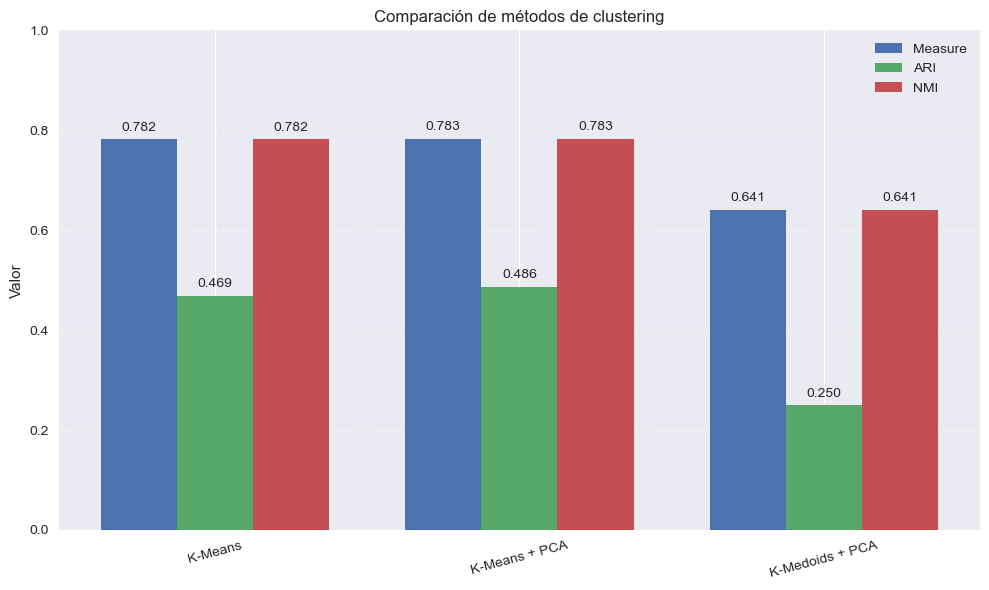

In [47]:
# Guardar los valores obtenidos
metodos = ["K-Means", "K-Means + PCA", "K-Medoids + PCA"]

measure_scores = [measure_kmeans, measure_kmeans_pca, measure_kmedoids]
ari_scores = [
    adjusted_rand_score(y_true, labels_kmeans), 
    adjusted_rand_score(y_true, y_pred_pca), 
    adjusted_rand_score(y_true, y_pred_kmedoids)
]
nmi_scores = [
    normalized_mutual_info_score(y_true, labels_kmeans),
    normalized_mutual_info_score(y_true, y_pred_pca),
    normalized_mutual_info_score(y_true, y_pred_kmedoids)
]

# Gráfico de barras agrupadas
x = np.arange(len(metodos))
width = 0.25  # ancho de cada barra

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - width, measure_scores, width, label="Measure")
bars2 = ax.bar(x, ari_scores, width, label="ARI")
bars3 = ax.bar(x + width, nmi_scores, width, label="NMI")

# Configuración del gráfico
ax.set_ylabel("Valor")
ax.set_title("Comparación de métodos de clustering")
ax.set_xticks(x)
ax.set_xticklabels(metodos, rotation=15)
ax.set_ylim(0, 1)
ax.legend()

# Mostrar valores en las barras
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f"{height:.3f}",
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 4), 
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()


Se realiza la predicción de clusters utilizando el algoritmo de Kmeloids con el mismo número de clusters y mismo valor semilla, llegando a las siguientes conclusiones sobre el desempeño de cada uno de los métodos utilizados.

- Desde el punto de vista del NMI, el Kmeans es el algoritmo con mejor desempeño, siendo el Kmeans con PCA el de mejor desempeño
- Desde el punto de vista del ARI, el Kmeans es el algoritmo con mejor desempeño, siendo el Kmeans con PCA el de mejor desempeño
- Desde el punto de vista del Measure, el Kmeans es el algoritmo con mejor desempeño, siendo el Kmeans sin PCA el de mejor desempeño
- En términos generales el Kmeans tiene un mejor desempeño que el Kmeloids, esto se debe a que los datos en escencia, no contaban con valores atípicos favoreciendo el desempeño del Kmeans frente al Kmeloids. Adicionalmente al tratarse de valores en escalas de grises (es decir valores no reales) el desempeño del Kmeloids no mejora frente al Kmeans debido los cálculos de distancia entre puntos restrictivos al "representante" de los datos como meloide.

### 4. Número de clusters óptimo

En el punto anteriores utilizamos nuestro conocimiento previo sobre los datos para elegir el número de clusters. En este punto, verifique si 40 es realmente el número de cluster que usted elegiría según los criterios estudiados en los cuadernos teóricos. Discuta los resultados obtenidos.

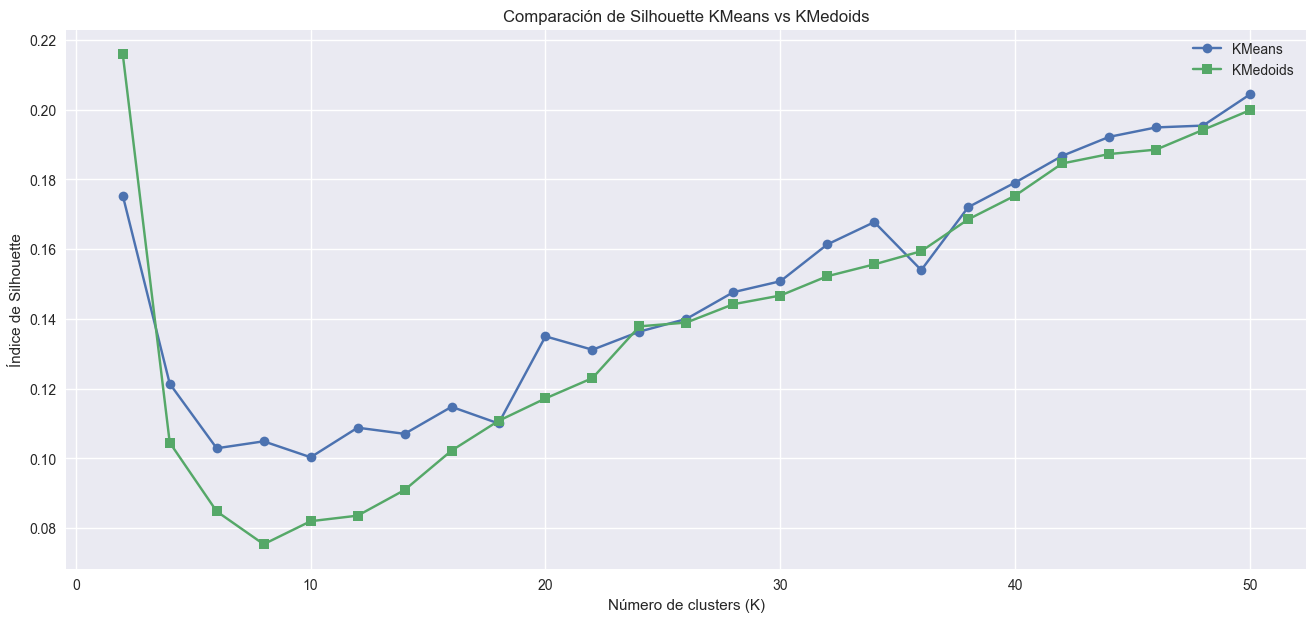

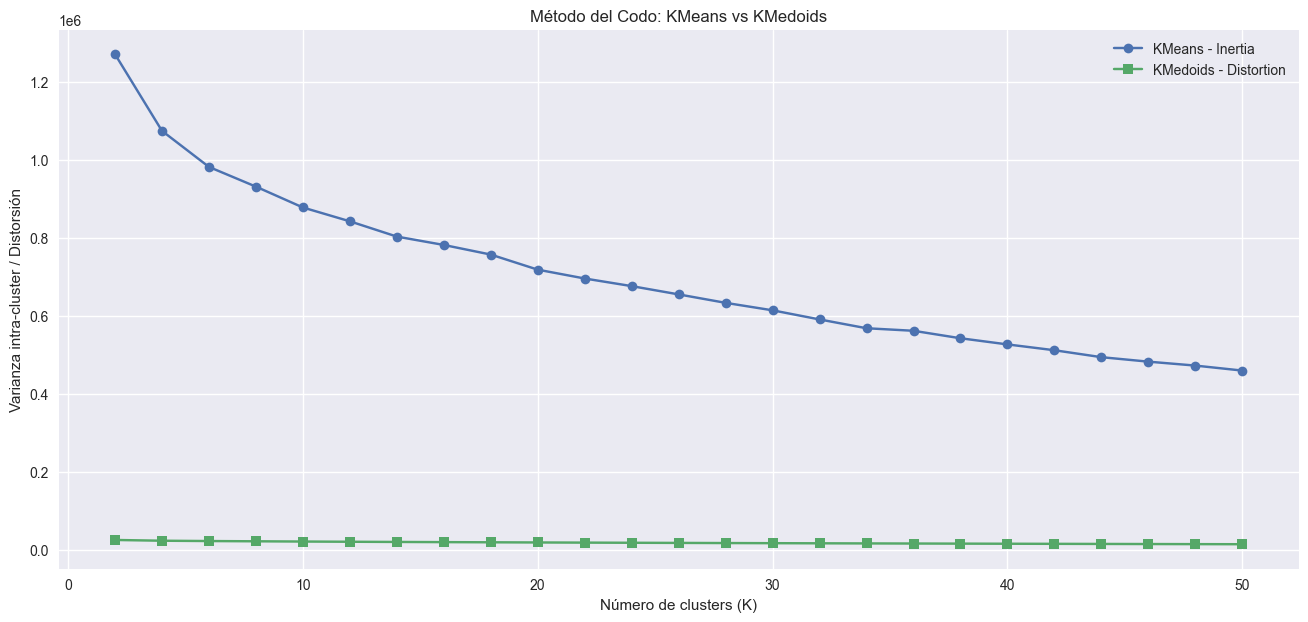

In [19]:
# Diccionarios para guardar resultados
Y = {"KMeans": {}, "KMedoids": {}}
silhouettes_kmeans, inertias_kmeans = [], []
silhouettes_kmedoids, distortions_kmedoids = [], []

# Rango de clusters
K_range = range(2, 51, 2)  # puedes ajustar el rango y el paso

for k in K_range:
    # --- KMeans ---
    kmeans = KMeans(n_clusters=k, random_state=123, n_init=10).fit(X_pca)
    inertias_kmeans.append(kmeans.inertia_)
    try:
        sil_kmeans = silhouette_score(X_pca, kmeans.labels_)
    except:
        sil_kmeans = 0
    silhouettes_kmeans.append(sil_kmeans)
    Y["KMeans"][k] = kmeans.labels_

    # --- KMedoids ---
    kmedoids = KMedoids(n_clusters=k, random_state=123, method="pam").fit(X_pca)
    distortions_kmedoids.append(kmedoids.inertia_)  # análogo a inertia
    try:
        sil_kmed = silhouette_score(X_pca, kmedoids.labels_)
    except:
        sil_kmed = 0
    silhouettes_kmedoids.append(sil_kmed)
    Y["KMedoids"][k] = kmedoids.labels_


# Visualización resultados
# Silhouette
plt.figure(figsize=(16, 7))
plt.plot(K_range, silhouettes_kmeans, marker='o', label="KMeans")
plt.plot(K_range, silhouettes_kmedoids, marker='s', label="KMedoids")
plt.xlabel("Número de clusters (K)")
plt.ylabel("Índice de Silhouette")
plt.title("Comparación de Silhouette KMeans vs KMedoids")
plt.legend()
plt.show()

# Inertia / Distorsión (Método del codo)
plt.figure(figsize=(16, 7))
plt.plot(K_range, inertias_kmeans, marker='o', label="KMeans - Inertia")
plt.plot(K_range, distortions_kmedoids, marker='s', label="KMedoids - Distortion")
plt.xlabel("Número de clusters (K)")
plt.ylabel("Varianza intra-cluster / Distorsión")
plt.title("Método del Codo: KMeans vs KMedoids")
plt.legend()
plt.show()


(Utilice este espacio para describir el procedimiento, análisis y conclusiones)
##### Índice de Silhouette (KMeans vs KMedoids)

- Ambos algoritmos presentan valores bajos de Silhouette (<0.25), lo que indica que los clusters no están muy bien separados (hay bastante solapamiento entre grupos).

- Para K pequeño (2–5 clusters):

    - KMeans tiene un comportamiento más estable, mientras que KMedoids muestra una caída fuerte después de $k=2$.

- A medida que aumenta $K$, ambos mejoran progresivamente, aunque siguen en valores bajos.

- El hecho de que la curva suba con $k$ es esperable: más clusters tienden a ajustarse mejor a los datos, pero no significa que la separación sea “natural” o interpretable.

*Conclusión Silhouette:* No existe un $k$ con separación clara; los valores bajos reflejan que los datos no tienen clusters muy definidos. Ambos algoritmos son comparables, pero KMeans suele ser más estable.

#####  Método del Codo (Inercia vs Distortion)

- KMeans (azul): La inercia disminuye de manera continua y suave, sin un “codo” pronunciado. Esto confirma que no hay un número de clusters óptimo claro en los datos: más clusters siempre reducen la inercia.

- KMedoids (verde): La “distorsión” se mantiene muy baja y casi constante en todos los valores de $k$. Esto sugiere que la métrica de inercia en KMedoids no aporta tanta información como en KMeans, o que los datos proyectados en PCA no muestran diferencias grandes entre clusters.

*Conclusión Método del Codo:* No aparece un “codo” definido el conjunto de datos no tiene una estructura de clusters fuerte. KMeans sigue mostrando mayor variación en la inercia, mientras que KMedoids parece más plano.

##### Interpretación General:

- Tanto Silhouette como Elbow indican que los datos no presentan clusters muy definidos.

- KMeans parece capturar un poco más de variabilidad en la separación de los clusters, mientras que KMedoids es más estable pero menos sensible.

- Esto es consistente con datasets de imágenes (como rostros) donde la separación en grupos no es nítida sin un preprocesamiento más especializado (e.g. embeddings de redes neuronales).